In [1]:
import pickle
import os
import sys

In [2]:
from collections import defaultdict
from utils.dict_utils import dict_to_defaultdict

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [803]:
dataset = 'cifar2_binary'
d0 = 3 * 32 * 32
num_classes = 2
train_size = 1000
num_hidden = 2
bias = False
normalization = 'none'
activation = 'lrelu'
optimizer = 'sgd'
num_seeds = 5
lr = 0.01

In [804]:
log_dir = os.path.join(
    'results', 'ref_width_dependence', '{}_{}'.format(dataset, train_size), 
    'num_hidden={}_activation={}_bias={}_normalization={}'.format(num_hidden, activation, bias, normalization), '{}_lr={}'.format(optimizer, lr))
    #'num_hidden={}_bias={}_normalization={}'.format(num_hidden, bias, normalization), '{}_lr={}'.format(optimizer, lr))
log_dir

'results/ref_width_dependence/cifar2_binary_1000/num_hidden=2_activation=lrelu_bias=False_normalization=none/sgd_lr=0.01'

In [805]:
results_all_path = os.path.join(log_dir, 'results_all.dat')
results_all = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan))))))
if os.path.exists(results_all_path):
    with open(results_all_path, 'rb') as f:
        results_all = dict_to_defaultdict(pickle.load(f), results_all)

In [725]:
scaling_modes = ['mean_field', 'ntk']
ref_widths = [32]
correction_epochs = [0]
real_widths = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [726]:
plt.rcParams.update({'font.size': 14})

In [727]:
def draw_curve(scaling_mode, ref_width, correction_epoch, key, q=0, idx=None, scale=1, threshold=1000, **kwargs):
    if idx is None:
        data = [[results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key] for real_width in real_widths] for seed in range(num_seeds)]
    else:
        data = [[results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key][idx] for real_width in real_widths] for seed in range(num_seeds)]
    data = np.array(data)
    data = data * scale * np.power(real_widths, q)
    data = np.clip(data, -threshold, threshold)
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(np.log2(real_widths), data_mean, **kwargs)
    plt.fill_between(
        np.log2(real_widths),
        data_mean - data_std, data_mean + data_std,
        alpha=0.3, **kwargs
    )
        

In [770]:
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (1,5))]
cmap = plt.get_cmap('tab10')
key_bases = ['test_loss', 'test_acc', 'train_loss', 'train_acc']
key_modifiers = [('final_', '')]
ylims = [(0.34,0.44), (0.8, 0.9), (0.0,0.5), (0.7,1.0)]

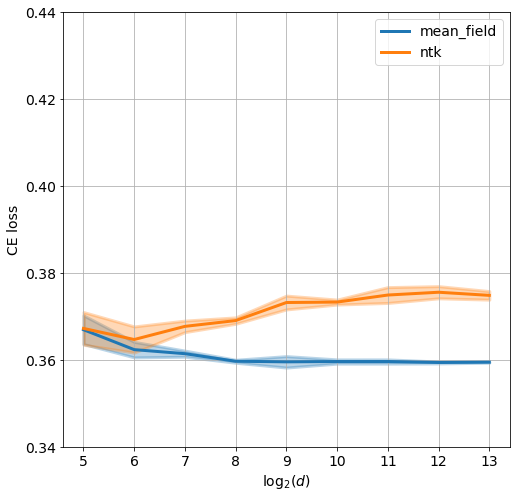

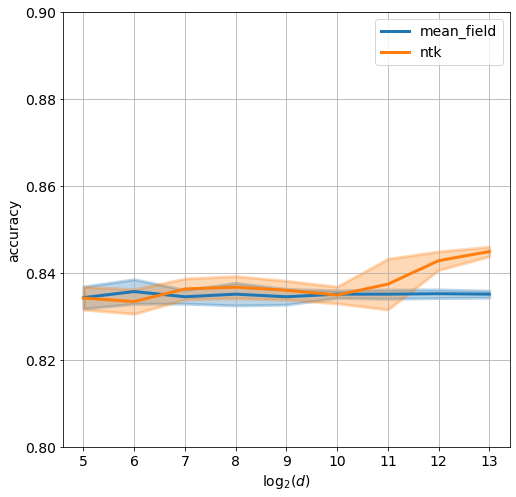

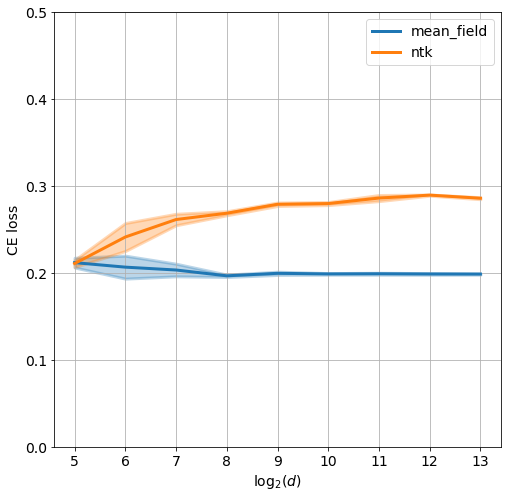

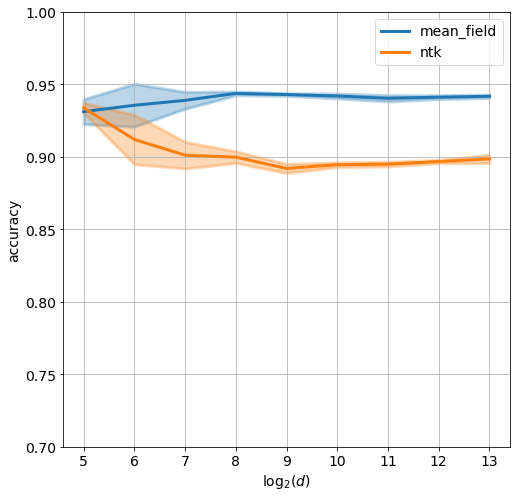

In [771]:
for key_base, ylim in zip(key_bases, ylims):
    _ = plt.figure(figsize=(8,8))

#     plt.title(
#         '{}: num_hidden={}, activation={}, optimizer={}, lr={}; {}_{}'.format(
#             key_base, num_hidden, activation, optimizer, lr, dataset, train_size
#         )
#     )
    
    plt.xlabel(r"$\log_2(d)$")
    plt.ylim(ylim)
    plt.grid(True)
    
    if key_base.endswith('_loss'):
        plt.ylabel("CE loss")
#         plt.plot(
#             np.log2(real_widths), np.zeros_like(real_widths) + np.log(num_classes), 
#             color='black', lw=3, ls='solid'
#         )
    elif key_base.endswith('_acc'):
        plt.ylabel("accuracy")
#         plt.plot(
#             np.log2(real_widths), np.zeros_like(real_widths) + 1 / num_classes, 
#             color='black', lw=3, ls='solid'
#         )

    for k, scaling_mode in enumerate(scaling_modes):
        for ref_width in (ref_widths if scaling_mode != 'default' else [None]):
            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                for i, key_mod in enumerate(key_modifiers):
                    key = key_mod[0] + key_base + key_mod[1]
                    if scaling_mode == 'default':
                        draw_curve(scaling_mode, ref_width, correction_epoch, key, color='black', linestyle='solid')
                    else:
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, color=cmap(k), 
                            linestyle=linestyles[i], lw=3
                        )
                    
    plt.legend(
        [
            '{}'.format(scaling_mode) 
            for scaling_mode in scaling_modes
        ]
    )
    plt.show()

In [772]:
key_bases = ['test_loss']
key_modifiers = [('final_', '0'), ('final_', '_a'), ('final_', '_w'), ('final_', '_avw'), ('init_', ''), ]
ylims = [(0.35,0.72), (0.5, 1.0), (0.0,0.72), (0.5,1.0)]

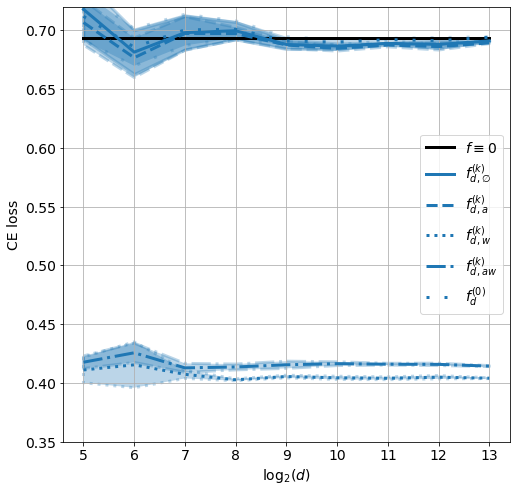

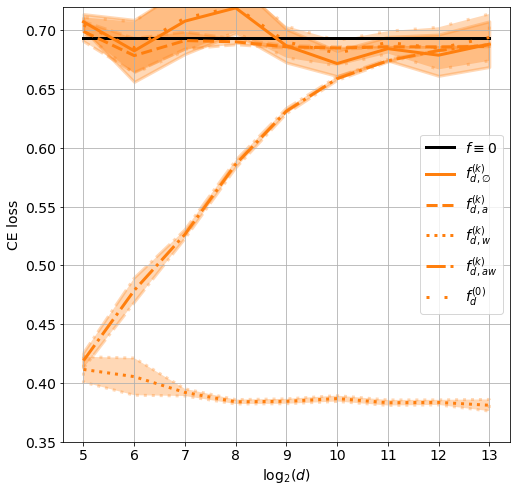

In [773]:
for key_base, ylim in zip(key_bases, ylims):
    for k, scaling_mode in enumerate(scaling_modes):
        _ = plt.figure(figsize=(8,8))

    #     plt.title(
    #         '{}: num_hidden={}, activation={}, optimizer={}, lr={}; {}_{}'.format(
    #             key_base, num_hidden, activation, optimizer, lr, dataset, train_size
    #         )
    #     )

        plt.xlabel(r"$\log_2(d)$")
        plt.ylim(ylim)
        plt.grid(True)

        if key_base.endswith('_loss'):
            plt.ylabel("CE loss")
            plt.plot(
                np.log2(real_widths), np.zeros_like(real_widths) + np.log(num_classes), 
                color='black', lw=3, ls='solid'
            )
        elif key_base.endswith('_acc'):
            plt.ylabel("accuracy")
            plt.plot(
                np.log2(real_widths), np.zeros_like(real_widths) + 1 / num_classes, 
                color='black', lw=3, ls='solid'
            )

        for ref_width in (ref_widths if scaling_mode != 'default' else [None]):
            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                for i, key_mod in enumerate(key_modifiers):
                    key = key_mod[0] + key_base + key_mod[1]
                    if scaling_mode == 'default':
                        draw_curve(scaling_mode, ref_width, correction_epoch, key, color='black', linestyle='solid')
                    else:
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, color=cmap(k), 
                            linestyle=linestyles[i], lw=3
                        )
                    
        plt.legend(
            [r'$f \equiv 0$'] +
            [
                '{}'.format(f_name) 
                for f_name in [r'$f_{d,\emptyset}^{(k)}$', r'$f_{d,a}^{(k)}$', r'$f_{d,w}^{(k)}$', r'$f_{d,aw}^{(k)}$', r'$f_d^{(0)}$']
            ]
        )
        plt.show()

In [774]:
def compute_q(scaling_mode, ref_width, correction_epoch, key, idx=None, d_seg_len=3, **kwargs):
    if idx is None:
        data = [[results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key] for real_width in real_widths] for seed in range(num_seeds)]
    else:
        data = [[results_all[scaling_mode][ref_width][correction_epoch][real_width][seed][key][idx] for real_width in real_widths] for seed in range(num_seeds)]
    data = np.array(data)
    data_mean = data.mean(axis=0)
    q = np.log2(data_mean[-1] / data_mean[-1-d_seg_len]) / d_seg_len
    return q

In [806]:
key_bases = ['var_f']
if num_hidden > 1:
    key_modifiers = [
        ('final_', '0'), 
        ('final_', '_a'), 
        ('final_', '_v'), 
        ('final_', '_w'), 
        ('final_', '_avw'),
    ]
    f_names = [
        r'$Var_x f_{d,\emptyset}^{(k)}(x)$', 
        r'$Var_x f_{d,a}^{(k)}(x)$', 
        r'$Var_x f_{d,v}^{(k)}(x)$', 
        r'$Var_x f_{d,w}^{(k)}(x)$', 
        r'$Var_x f_{d,avw}^{(k)}(x)$'
    ]
else:
    key_modifiers = [
        ('final_', '0'), 
        ('final_', '_a'), 
        ('final_', '_w'), 
        ('final_', '_avw'),
    ]
    f_names = [
        r'$Var_x f_{d,\emptyset}^{(k)}(x)$', 
        r'$Var_x f_{d,a}^{(k)}(x)$', 
        r'$Var_x f_{d,w}^{(k)}(x)$', 
        r'$Var_x f_{d,aw}^{(k)}(x)$'
    ]

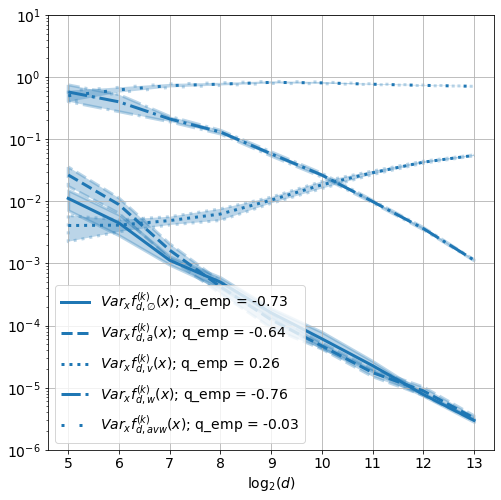

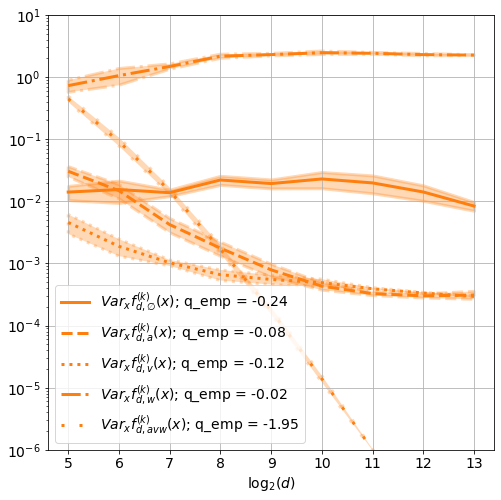

In [807]:
for key_base, ylim in zip(key_bases, ylims):
    for k, scaling_mode in enumerate(scaling_modes):
        _ = plt.figure(figsize=(8,8))

    #     plt.title(
    #         '{}: num_hidden={}, activation={}, optimizer={}, lr={}; {}_{}'.format(
    #             key_base, num_hidden, activation, optimizer, lr, dataset, train_size
    #         )
    #     )

        plt.xlabel(r"$\log_2(d)$")
        plt.ylim((1e-6,1e1))
        plt.yscale('log')
        plt.grid(True)
        
        qs = []

        for ref_width in (ref_widths if scaling_mode != 'default' else [None]):
            for correction_epoch in (
                correction_epochs if scaling_mode.startswith('mean_field') else [None]
            ):
                if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                    continue
                for i, key_mod in enumerate(key_modifiers):
                    key = key_mod[0] + key_base + key_mod[1]
                    if key_mod[1] == '_v':
                        idx = 0
                    else:
                        idx = None
                    if scaling_mode == 'default':
                        draw_curve(scaling_mode, ref_width, correction_epoch, key, color='black', linestyle='solid')
                    else:
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, idx=idx, color=cmap(k), 
                            linestyle=linestyles[i], lw=3
                        )
                        qs.append(compute_q(scaling_mode, ref_width, correction_epoch, key, idx=idx, d_seg_len=3) / 2)
                    
        plt.legend(
            [
                '{}; q_emp = {:.2f}'.format(f_name, q) 
                for f_name, q in zip(f_names, qs)
            ]
        )
        plt.show()

In [765]:
keys = ['input_weight_mean_abs_inc', 'hidden_weight_mean_abs_inc', 'output_weight_mean_abs_inc']
key_names = [
    r'$\|\delta \hat\mathbf{w}^{(k)}\| / d^{q_w^{(k)}}$', 
    r'$|\delta \hat v^{(k)}| / d^{q_v^{(k)}}$', 
    r'$|\delta \hat a^{(k)}| / d^{q_a^{(k)}}$'
]

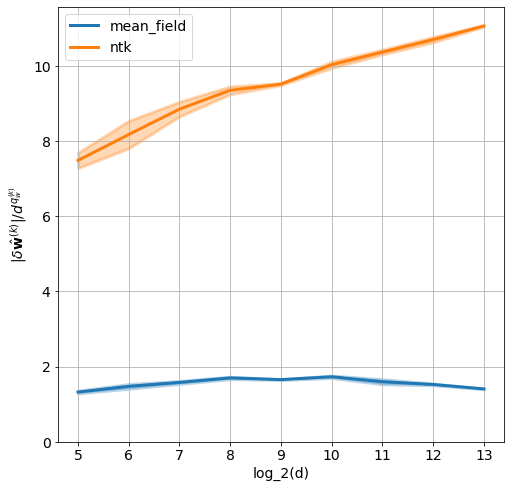

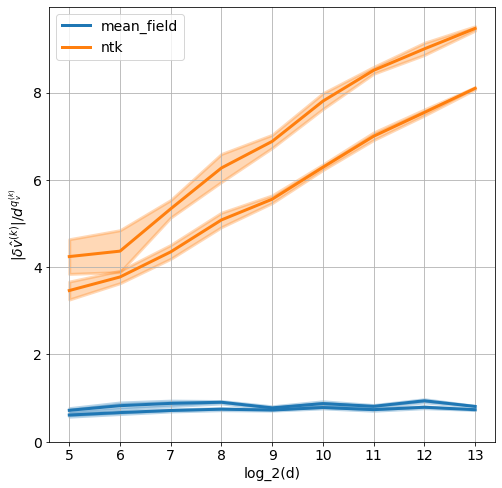

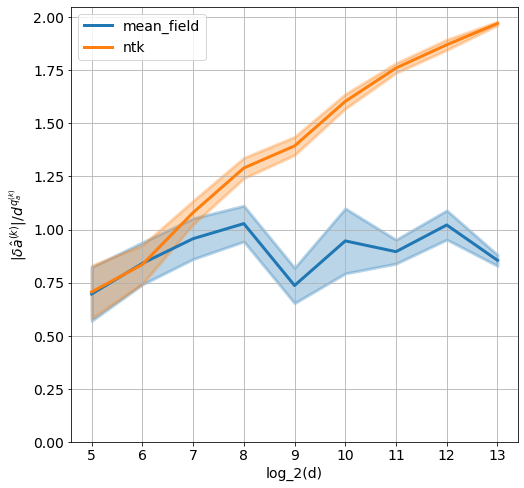

In [766]:
for i, (key_name, key) in enumerate(zip(key_names, keys)):
    _ = plt.figure(figsize=(8,8))

#     plt.title(
#         '{}: num_hidden={}, activation={}, optimizer={}, lr={}; {}_{}'.format(
#             key_name, num_hidden, activation, optimizer, lr, dataset, train_size
#         )
#     )

    plt.xlabel("log_2(d)")
    plt.ylabel(key_name)
    plt.grid(True)
    
    if key == 'input_weight_mean_abs_inc':
        scale = 1
    else:
        scale = 1

    for idx in (range(num_hidden-1) if key == 'hidden_weight_mean_abs_inc' else [None]):
        for k, scaling_mode in enumerate(scaling_modes):
            if scaling_mode == 'mean_field':
                q = [0, 1, 1][i]
            elif scaling_mode == 'ntk':
                q = [0.5, 1.5, 1][i]
            for ref_width in (ref_widths if scaling_mode != 'default' else [None]):
                for correction_epoch in (
                    correction_epochs if scaling_mode.startswith('mean_field') else [None]
                ):
                    if correction_epoch == 0 and scaling_mode == 'mean_field_var1':
                        continue
                    if scaling_mode == 'default':
                        draw_curve(scaling_mode, ref_width, correction_epoch, key, 
                                   q=q, color='black', linestyle='solid', lw=3)
                    else:
                        draw_curve(
                            scaling_mode, ref_width, correction_epoch, key, 
                            q=q, idx=idx, scale=scale, color=cmap(k), 
                            linestyle='solid', lw=3
                        )

    plt.legend(
        [
            '{}'.format(scaling_mode) 
            for scaling_mode in scaling_modes
        ]
    )
    plt.ylim(bottom=0)
    plt.show()